In [103]:
using JuMP


In [104]:
import Pkg
Pkg.add("Ipopt")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [11]:
import Pkg
Pkg.add("Plots")

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


   Installed JpegTurbo_jll ──────────────── v2.1.2+0
   Installed x265_jll ───────────────────── v3.5.0+0
   Installed libfdk_aac_jll ─────────────── v2.0.2+0
   Installed Libmount_jll ───────────────── v2.35.0+0
   Installed GR_jll ─────────────────────── v0.71.3+0
   Installed LERC_jll ───────────────────── v3.0.0+1
   Installed Opus_jll ───────────────────── v1.3.2+0
   Installed LoggingExtras ──────────────── v1.0.0


   Installed Grisu ──────────────────────── v1.0.2


   Installed Formatting ─────────────────── v0.4.2
   Installed Measures ───────────────────── v0.3.2
   Installed RelocatableFolders ─────────── v1.0.0
   Installed Xorg_xkbcomp_jll ───────────── v1.4.2+4


   Installed Xorg_xcb_util_wm_jll ───────── v0.4.1+1


   Installed PlotUtils ──────────────────── v1.3.2
   Installed RecipesPipeline ────────────── v0.6.11
   Installed Xorg_xcb_util_image_jll ────── v0.4.0+1
   Installed OpenSSL ────────────────────── v1.3.2
   Installed Xorg_libpthread_stubs_jll ──── v0.1.0+3
   Installed Contour ────────────────────── v0.6.2


   Installed Xorg_xcb_util_jll ──────────── v0.4.0+1
   Installed Libgpg_error_jll ───────────── v1.42.0+0
   Installed Cairo_jll ──────────────────── v1.16.1+1
   Installed Fontconfig_jll ─────────────── v2.13.93+0


   Installed Xorg_libxkbfile_jll ────────── v1.1.0+4
   Installed HTTP ───────────────────────── v1.6.3
   Installed Xorg_libXinerama_jll ───────── v1.1.4+4


   Installed Xorg_libXau_jll ────────────── v1.0.9+4
   Installed Qt5Base_jll ────────────────── v5.15.3+2
   Installed FFMPEG ─────────────────────── v0.4.1


   Installed Missings ───────────────────── v1.1.0
   Installed Showoff ────────────────────── v1.0.3
   Installed Xorg_xcb_util_keysyms_jll ──── v0.4.0+1


   Installed xkbcommon_jll ──────────────── v1.4.1+0
   Installed SimpleBufferStream ─────────── v1.1.0
   Installed HarfBuzz_jll ───────────────── v2.8.1+1
   Installed Pipe ───────────────────────── v1.3.0
   Installed LZO_jll ────────────────────── v2.10.1+0
   Installed PlotThemes ─────────────────── v3.1.0


   Installed fzf_jll ────────────────────── v0.29.0+0
   Installed FriBidi_jll ────────────────── v1.0.10+0
   Installed x264_jll ───────────────────── v2021.5.5+0
   Installed GLFW_jll ───────────────────── v3.3.8+0
   Installed UnicodeFun ─────────────────── v0.4.1


   Installed MbedTLS ────────────────────── v1.1.7


   Installed FreeType2_jll ──────────────── v2.10.4+0
   Installed JLFzf ──────────────────────── v0.1.5
   Installed StatsAPI ───────────────────── v1.5.0


   Installed Xorg_libxcb_jll ────────────── v1.13.0+3
   Installed libpng_jll ─────────────────── v1.6.38+0


   Installed libaom_jll ─────────────────── v3.4.0+0
   Installed StatsBase ──────────────────── v0.33.21


   Installed Scratch ────────────────────── v1.1.1
   Installed Xorg_libXext_jll ───────────── v1.3.4+4


   Installed TensorCore ─────────────────── v0.1.1


   Installed Zstd_jll ───────────────────── v1.5.2+0
   Installed Expat_jll ──────────────────── v2.4.8+0
   Installed Libtiff_jll ────────────────── v4.4.0+0
   Installed ColorVectorSpace ───────────── v0.9.10
   Installed Plots ──────────────────────── v1.38.1


   Installed Xorg_libXrender_jll ────────── v0.9.10+4
   Installed Libffi_jll ─────────────────── v3.2.2+1
   Installed Xorg_libXi_jll ─────────────── v1.7.10+4
   Installed Ogg_jll ────────────────────── v1.3.5+1
   Installed XSLT_jll ───────────────────── v1.1.34+0
   Installed Xorg_libXcursor_jll ────────── v1.2.0+4


   Installed Libuuid_jll ────────────────── v2.36.0+0
   Installed Wayland_protocols_jll ──────── v1.25.0+0


   Installed Xorg_xcb_util_renderutil_jll ─ v0.3.9+1
   Installed Pixman_jll ─────────────────── v0.40.1+0
   Installed Graphite2_jll ──────────────── v1.3.14+0
   Installed libass_jll ─────────────────── v0.15.1+0


   Installed XML2_jll ───────────────────── v2.10.3+0


   Installed Gettext_jll ────────────────── v0.21.0+0
   Installed Wayland_jll ────────────────── v1.21.0+0
   Installed Xorg_xtrans_jll ────────────── v1.4.0+3
   Installed OpenSSL_jll ────────────────── v1.1.19+0
   Installed Latexify ───────────────────── v0.15.17
   Installed BitFlags ───────────────────── v0.1.7


   Installed FFMPEG_jll ─────────────────── v4.4.2+2
   Installed Xorg_libXrandr_jll ─────────── v1.5.2+4
   Installed RecipesBase ────────────────── v1.3.2
   Installed Libgcrypt_jll ──────────────── v1.8.7+0
   Installed DataAPI ────────────────────── v1.14.0
   Installed Xorg_xkeyboard_config_jll ──── v2.27.0+4


   Installed Xorg_libXfixes_jll ─────────── v5.0.3+4
   Installed LAME_jll ───────────────────── v3.100.1+0
   Installed Glib_jll ───────────────────── v2.74.0+2
   Installed Libiconv_jll ───────────────── v1.16.1+2
   Installed IniFile ────────────────────── v0.5.1
   Installed URIs ───────────────────────── v1.4.1


   Installed libvorbis_jll ──────────────── v1.3.7+1
   Installed Libglvnd_jll ───────────────── v1.6.0+0
   Installed Xorg_libXdmcp_jll ──────────── v1.1.3+4
   Installed Xorg_libX11_jll ────────────── v1.6.9+4
   Installed SortingAlgorithms ──────────── v1.1.0
   Installed Unzip ──────────────────────── v0.2.0


   Installed ColorSchemes ───────────────── v3.20.0


   Installed GR ─────────────────────────── v0.71.3


    Updating `~/.julia/environments/v1.8/Project.toml`
  [91a5bcdd] + Plots v1.38.1
    Updating `~/.julia/environments/v1.8/Manifest.toml`


  [d1d4a3ce] + BitFlags v0.1.7
  [35d6a980] + ColorSchemes v3.20.0
  [c3611d14] + ColorVectorSpace v0.9.10
  [d38c429a] + Contour v0.6.2
  [9a962f9c] + DataAPI v1.14.0
  [c87230d0] + FFMPEG v0.4.1
  [59287772] + Formatting v0.4.2
  [28b8d3ca] + GR v0.71.3
  [42e2da0e] + Grisu v1.0.2
  [cd3eb016] + HTTP v1.6.3
  [83e8ac13] + IniFile v0.5.1
  [1019f520] + JLFzf v0.1.5
  [23fbe1c1] + Latexify v0.15.17
  [e6f89c97] + LoggingExtras v1.0.0
  [739be429] + MbedTLS v1.1.7
  [442fdcdd] + Measures v0.3.2
  [e1d29d7a] + Missings v1.1.0
  [4d8831e6] + OpenSSL v1.3.2
  [b98c9c47] + Pipe v1.3.0
  [ccf2f8ad] + PlotThemes v3.1.0
  [995b91a9] + PlotUtils v1.3.2
  [91a5bcdd] + Plots v1.38.1
  [3cdcf5f2] + RecipesBase v1.3.2
  [01d81517] + RecipesPipeline v0.6.11
  [05181044] + RelocatableFolders v1.0.0
  [6c6a2e73] + Scratch v1.1.1
  [992d4aef] + Showoff v1.0.3
  [777ac1f9] + SimpleBufferStream v1.1.0
  [a2af1166] + SortingAlgorithms v1.1.0
  [82ae8749] + StatsAPI v1.5.0
  [2913bbd2] + StatsBase v0.33.21

Precompiling 

project...


  ✓ StatsAPI
  ✓ Pipe
  ✓ IniFile
  ✓ TensorCore
  ✓ Contour


  ✓ Measures


  ✓ Unzip


  ✓ Grisu


  ✓ PCRE2_jll


  ✓ SimpleBufferStream


  ✓ URIs
  ✓ Formatting
  ✓ UnicodeFun
  ✓ DataAPI
  ✓ BitFlags
  ✓ Scratch
  ✓ LoggingExtras


  ✓ MbedTLS


  ✓ RecipesBase
  ✓ Xorg_libXau_jll


  ✓ Libmount_jll
  ✓ LAME_jll


  ✓ OpenSSL_jll
  ✓ Graphite2_jll
  ✓ libfdk_aac_jll


  ✓ libpng_jll


  ✓ Pixman_jll


  ✓ JpegTurbo_jll


  ✓ LERC_jll


  ✓ Xorg_libXdmcp_jll


  ✓ fzf_jll


  ✓ libaom_jll
  ✓ x264_jll


  ✓ Ogg_jll


  ✓ x265_jll


  ✓ LZO_jll


  ✓ Xorg_xtrans_jll
  ✓ Zstd_jll


  ✓ Opus_jll


  ✓ Expat_jll
  ✓ Libffi_jll


  ✓ Libgpg_error_jll


  ✓ Libiconv_jll
  ✓ Wayland_protocols_jll


  ✓ Xorg_libpthread_stubs_jll
  ✓ FriBidi_jll
  ✓ Libuuid_jll
  ✓ Showoff
  ✓ Missings


  ✓ FreeType2_jll
  ✓ SortingAlgorithms


  ✓ RelocatableFolders


  ✓ libvorbis_jll


  ✓ Libtiff_jll


  ✓ JLFzf


  ✓ XML2_jll


  ✓ Libgcrypt_jll


  ✓ Fontconfig_jll


  ✓ Gettext_jll


  ✓ Wayland_jll


  ✓ XSLT_jll


  ✓ Glib_jll


  ✓ Xorg_libxcb_jll


  ✓ OpenSSL


  ✓ Xorg_xcb_util_jll


  ✓ Xorg_libX11_jll


  ✓ Latexify


  ✓ Xorg_xcb_util_keysyms_jll


  ✓ Xorg_xcb_util_renderutil_jll


  ✓ Xorg_xcb_util_wm_jll


  ✓ Xorg_libXrender_jll


  ✓ Xorg_xcb_util_image_jll


  ✓ StatsBase


  ✓ Xorg_libXext_jll


  ✓ Xorg_libXfixes_jll


  ✓ Xorg_libxkbfile_jll


  ✓ Xorg_libXrandr_jll


  ✓ Libglvnd_jll
  ✓ Xorg_libXinerama_jll


  ✓ ColorVectorSpace


  ✓ Cairo_jll


  ✓ Xorg_libXcursor_jll


  ✓ Xorg_libXi_jll


  ✓ Xorg_xkbcomp_jll


  ✓ HarfBuzz_jll


  ✓ GLFW_jll


  ✓ Xorg_xkeyboard_config_jll


  ✓ libass_jll


  ✓ xkbcommon_jll


  ✓ FFMPEG_jll


  ✓ Qt5Base_jll


  ✓ FFMPEG


  ✓ HTTP


  ✓ GR_jll


  ✓ GR


  ✓ ColorSchemes


  ✓ PlotUtils


  ✓ PlotThemes


  ✓ RecipesPipeline


  ✓ Plots



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:        0



  100 dependencies successfully precompiled in 243 seconds. 62 already precompiled.


### COM361 &mdash; Introdução a Otimização &mdash; 2022, Prof. Amit ###

# Otimização de Wifi #

#### Pedro Henrique de Jesus Teixeira (pedroteixeir@poli.ufrj.br), Diego Nunes Gonçalves Freitas (diegongfreitas@poli.ufrj.br)

*****

### Índice

1. [Introdução](#1.-Introdução)
1. [Modelo Matemático](#2.-Modelo Mathemático)
1. [Solução](#3.-Solução)
1. [Resultados e Discussão](#4.-Resultados-e-discussão)
  1. [Subseção Opcional](#4.A.-Acrescente-subseções-se-necessário)
1. [Conclusão](#5.-Conclusão)
1. [Referências bibliográficas] (#6.-Referências bibliográficas)

## 1. Introdução ##

O projeto a ser apresentado ao longo desse relatório consiste em um mecânismo de otimização do posicionamento de um roteador wifi em um estabelecimento ou residência. Faremos isso porcurando o melhor ponto de instalação de um roteador objetivando a maximização da força do sinal que chega aos dispositivos conectados. 

É muito comum perceber cômodos de sua casa em que o sinal wifi chega muito enfraquecido ou simplesmente não chega, chamaremos essas regiões de Zonas Mortas. Denominamos de Zonas Críticas os cômodos nos quais há um dispositivo conectado a rede. Além de maximizar o sinal em cada dispositivo conectado precisamos, também, eliminar a possibilidade de formação de Zonas Mortas em Zonas Críticas. A complexidade dos cenários de teste do nosso algoritmo cresce gradualmente, conforme aumentamos a planta do imóvel e adicionamos fontes de interferência como espelhos, madeira, móveis metálicos, etc. 

O primeiro padrão de conexão wifi surgiu em 1997. Com o passar dos anos essa tecnologia se popularizou e, nos dias atuais, quase todo estabelecimento ou residência possui uma rede de internet via Wifi. Com a expansão dessa tecnologia suas qualidades e defeitos foram ficando mais evidentes. Um dos mais evidentes defeitos é a grande dependência do funcionamento ótimo da rede ao posicionamento do roteador wifi. Se mal posicionado em uma residência, o roteador pode acabar entregando, aos seus dispositivos conectados, porcentagens incrivelmente pequenas do sinal original. 

Nosso projeto tratará sobre redes [WLAN](https://pt.wikipedia.org/wiki/Rede_de_área_local_sem_fio), ou seja, redes de area local sem fio que usam ondas de rádio para fazer a conexão entre os dispositivos. Para fins de simplificação, os dados relacionados à perda de sinal ao longo da distância e por meio de interferências foram sintetizados e previamente estabelecidos.

A partir desse ponto apresentaremos o desenvolvimento do projeto, começando pelo modelo matématico na seção 2. Em seguida, na seção 3, apresentamos nossa solução de otimização, desenvolvida em Julia 1.8.0, possível de ser rodada nesse notebook Jupyter. Na seção 4, evidenciamos nossos resultados para cada cenário, variando em graus de complexidade, através de plots simulando um ambiente de rede. Na seção 5, finalizamos a apresentação do projeto apresentando nossas conclusões acerca dos resultados obtidos e dos métodos utilizados, ressaltando aspectos passíveis de melhorias. Por fim, na seção 6, apresentamos as referencias biubliográficas utilizadas ao longo do desenvolvimento do projeto.

## 2. Modelo matemático ##
Para abordar melhor nosso problema representamos o ambiente do imóvel trabalhado como uma matriz $A_{mXn}$. Começaremos apresentando nossas variáveis
de decisão. 

Denominamos $C_{ij}$, um posição da matriz em que há um dispositivo conectado a rede, sendo $c$ o número de dispositivos.

Denominamos $R_{ij}$, uma posição da matriz em que há um roteador.

O valor registrado em cada posição da matriz determinará o que esta presente naquele local da forma:
$$
a_{ij} = 
\begin{cases}
2, \text{ caso haja um roteador naquele local}\\
1, \text{ caso haja um dispositivo conectato naquele local}\\
0, \text{ caso não haja nada relacionado a rede naquele local}
\end{cases}
$$

Sopomos então que, a distância $d$ entre um roteador e um dispositivo, dada por:
$$
d = R_{ij} - C_{ij}
$$
influencia linearmente na força $f_{ij}$ do sinal que chega ao dispositivo na posição ij, da seguinte forma.
$$
f_{ij} = 1 - 0.2d 
$$

Primeiramente a posição de cada dispositivo sera dada aleatoriamente na matriz. 

Nosso objetivo será encontrar a posição para o roteador que maximize a soma das forças do sinal em cada dispositivo. 

Além disso, evitaremos grandes variações para a força do sinal em cada dispositivo, limitando o desvio padrão entre eles, sendo esse denominado $\sigma_f$.

Exemplificando o posicionamento ótimo de um roteador para um caso simples:
$$
\begin{bmatrix}
  1 & 0 & 0 & 2 & 0 & 0 & 1\\
  0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}
$$

Dessa forma, nosso problema de otimização em forma padrão fica assim:
$$
\begin{aligned}
\underset{x \in \mathbb{R^n}}{\text{maximize}}\qquad& \sum_{k=0}^{c}{f_k(d)} \\
\text{sujeito a:}\qquad& \sigma_{f(d)} \le 0,4\\
& d > 0
\end{aligned}
$$

Vamos trabalhar ainda com casos em que há objetos no estabelecimento que causem interferência no sinal, gerando Zonas mortas. Para isso iremos alterar um pouco nosso cenário:

$$
a_{ij} = 
\begin{cases}
3, \text{ caso haja uma fonte de interferência naquele local}\\
2, \text{ caso haja um roteador naquele local}\\
1, \text{ caso haja um dispositivo conectato naquele local}\\
0, \text{ caso não haja nada relacionado a rede naquele local}
\end{cases}
$$

Exemplificando, agora, o posicionamento ótimo de um roteador para um caso com interferência:

Se mantivermos o roteador na mesma posição um dos dispositivos ficaria em uma zona morta
$$
\begin{bmatrix}
  1 & 0 & 0 & 2 & 3 & 0 & 1\\
  0 & 0 & 0 & 0 & 3 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}
$$
Para solucionar esse problema o roteador deve ser movido de forma a alterar a região de Zona morta, da seguinte forma:
$$
\begin{bmatrix}
  1 & 0 & 0 & 0 & 3 & 0 & 1\\
  0 & 0 & 0 & 0 & 3 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 2 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}
$$

Isso encerra o modelo matemático do nosso projeto. Em seguida apresentaremos nossa solução.



## 3. Solução ##

Nesta seção, coloque seu código em Julia + JuMP e resolva o problema proposto. Seu código deve ser limpo (não macarrônico!), de fácil leitura, bem comentado e anotado e deve compilar sem erros em Julia 1.x, x $\geq 1$! Não valem códigos em outras linguagens. **Vou rodar seu código para avaliar seu projeto**. Sugiro a utilização de múltiplos blocos de códigos separados por blocos de texto (células Markdown) explicando as várias partes da sua solução. Sugiro também a resolução de várias versões do seu problema, com modelos e hipóteses diferentes.

É permitido chamar pacotes externos, mas evite a utilização de bibliotecas exóticas (pois, em geral, não rodam em todas as versões de Julia, e terei que instalar a mesma versão que você usou, ou rodar na plataforma Google Colab, que gostaria de evitar).

In [79]:
# Este nosso modelo matematico
using JuMP, Ipopt, Statistics, LinearAlgebra, PolygonOps

m = Model(Ipopt.Optimizer)
apartamento = zeros(4,4)
interferencias = false                                                  # esta é matriz que define o tamanho do apartamento
interferencias = [ [[0,2] , [1,2]]]                                     # posições bidimensionais das interferencias
dispositivos = [[0,0],[0,4]]
decaimento = 0.2
alcance = 1/decaimento
function in_low_circle(x,y,x_dev,y_dev)
    for interferencia in interferencias
        oa = [interferencia[1][1] - x, interferencia[1][2] - y, 0 ]
        op = [x_dev - x, y_dev - y, 0   ]
        ab = [interferencia[2][1] - interferencia[1][1], interferencia[2][2]- interferencia[1][2], 0]
        ap = [x_dev - interferencia[1][1],  y_dev - interferencia[1][2], 0  ]
        ob = [interferencia[2][1] - x,interferencia[2][2] - y, 0 ]
        if cross(oa,op)[3] <=0 && cross(ab,ap)[3] >=0 && cross(ob,op)[3] >=0
            return 1
        end
    end
    return 0
end

function projection(x,y)
    for interferencia in interferencias
        u = [interferencia[1][1], interferencia[2][1]]
        v = [interferencia[1][2], interferencia[2][2]]
    end
    
    candidatop1x_1 = x + alcance*(u[1]-x)/(sqrt((u[1]-x)^2+(v[1]-y)^2))
    candidatop1x_2 = x - alcance*(u[1]-x)/(sqrt((u[1]-x)^2+(v[1]-y)^2))
    
    if u[1]==x
        proj_1x = x
    elseif  u[1] < x 
        if candidatop1x_1 < u[1]
            proj_1x = candidatop1x_1
        else
            proj_1x = candidatop1x_2
        end 
    else
        if candidatop1x_1 > u[1]
            proj_1x = candidatop1x_1
        else
            proj_1x = candidatop1x_2
        end
    end
    proj_1y = y + ((proj_1x-x)*(v[1]-y))/(u[1]-x)
    proj_1 = [proj_1x,proj_1y]

    candidatop2x_1 = x + alcance*(u[2]-x)/(sqrt((u[2]-x)^2+(v[2]-y)^2))
    candidatop2x_2 = x - alcance*(u[2]-x)/(sqrt((u[2]-x)^2+(v[2]-y)^2))
    
    if u[2] == x
        proj_2x = x
    elseif  u[2] < x 
        if candidatop2x_1 < u[2]
            proj_2x = candidatop2x_1
        else
            proj_2x = candidatop2x_2
        end 
    else
        if candidatop2x_1 > u[2]
            proj_2x = candidatop2x_1
        else
            proj_2x = candidatop2x_2
        end
    end
    proj_2y = y + ((proj_2x-x)*(v[2]-y))/(u[2]-x)
    proj_2 = [proj_2x,proj_2y]

    return proj_1, proj2
end

function in_polygon(x,y,x_dev,y_dev)
    for interferencia in interferencias
        proj_1 = [(5*cos(atan(interferencia[1][2]/interferencia[1][1])))+x, (5*sin(atan(interferencia[1][2]/interferencia[1][1])))+y] 
        proj_2 = [(5*cos(atan(interferencia[2][2]/interferencia[2][1])))+x, (5*sin(atan(interferencia[2][2]/interferencia[2][1])))+y]
        if inpolygon([x_dev,y_dev],[interferencia[1],interferencia[2],proj_2,proj_1,interferencia[1]]) == 1
            return 1
        end
    end
    return 0
end 

function force(x,y, std_dev)
    forca = []
    for i in dispositivos
        distancia = sqrt((x-i[1])^2+(y-i[2])^2) # a distancia entre o roteador e os dispositivos ´pode ser calculado pela distancia euclidiana
        f_= 1-0.2*distancia                     # a forca do sinal definida pela funcao apresentada no modelo matematico
        if f_ < 0
            f_ = 0                              # não é possivel ter sinais negativos
        else
            if in_polygon(x,y,i[1],i[2]) == 1 || in_low_circle(x,y,i[1],i[2]) == 1
                f_ = 0
            end
        end
        push!(forca,f_)
    end
    if std_dev == 1
        return Statistics.std(forca)
    elseif std_dev == -1
        return forca
    else
        return sum(forca)
    end
end

register(m, :interference, 4, interference, autodiff=true)
register(m, :force, 3, force, autodiff=true)
@variable(m, 0 <= x <= size(apartamento)[1])                            # as posições devem ser positivas
@variable(m, 0 <= y <= size(apartamento)[2])                            # as posições devem ser positivas e os roteadores da matriz não podem ser posicionados fora dos limites do apartamento
@NLconstraint(m, force(x,y,1)<= 0.1)
# @NLconstraint(m, )
@NLobjective(m, Max, force(x,y,0))                 # queremos maximizar a soma do sinal de wifi

optimize!(m)

println("x =", JuMP.value.(x))     # imprime o resultado na tela
println("y =", JuMP.value.(y))     # imprime o resultado na tela


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.9717158e-01 6.05e-01 4.06e-02   0.0 0.00e+00    -  0.00e+00 0.00e+00  

**Tenha certeza de que seu código compila corretamente! Rodarei seu código!**

## 4. Resultados e discussão ##

Neste seção, os resultados obtidos serão exibidos e discutidos. Mostre figuras, gráficos, imagens, curvas de compromisso, e o que mais puder melhor ilustrar seus resultados. A discussão deverá explicar o que significam os resultados e como interpretá-los. As limitações da sua abordagem/modelo também devem ser colocadas, bem como uma análise da sensibilidade dos resultados em relação às hipóteses feitas.


Utilize plots (veja exemplos  `PyPlot` [aqui](https://gist.github.com/gizmaa/7214002))

Aqui está um exemplo de uma tabela (em Markdown):

| Tabelas        | São           | Boas  |
| ------------- |:-------------:| -----:|
| col 3 é      | alinhado à direita |\$1600 |
| col 2 é      | centrado      |  \$12 |
| texto | também serve      |   \$1 |

### 4.A. Modelo visual da posição dos objetos


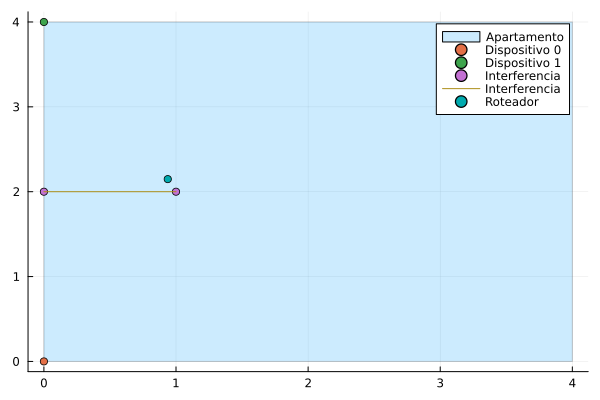

In [86]:
using Plots
rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])
plot(rectangle(4,4,0,0), label="Apartamento", opacity=.2)
i=0
for dispositivo in dispositivos 
    scatter!([dispositivo[1]],[dispositivo[2]], label="Dispositivo "*string(i))
    i+=1
end
for interferencia in interferencias
    scatter!([interferencia[1][1],interferencia[2][1]],[interferencia[1][2],interferencia[2][2]],label="Interferencia")
    plot!([interferencia[1][1],interferencia[2][1]],[interferencia[1][2],interferencia[2][2]],label="Interferencia")
end
scatter!([JuMP.value.(x)],[JuMP.value.(y)], label="Roteador")

In [64]:
println(force(JuMP.value.(x),JuMP.value.(y),-1))
println(force(JuMP.value.(x),JuMP.value.(y),1))

Any[0.531215821720444, 0.5848932080924498]
0.03795564390001568


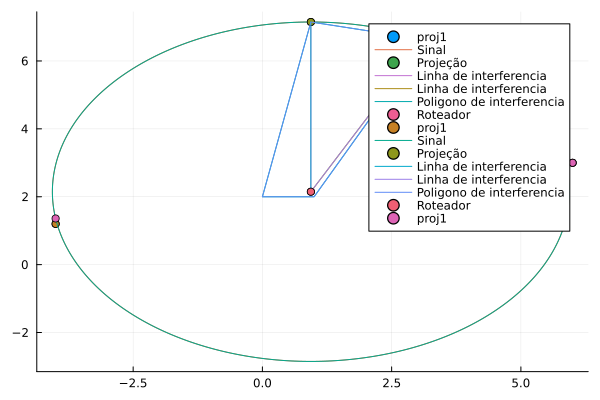

In [58]:
using Plots
function circleShape(x,y,r)
    teta = LinRange(0,2*pi, 500)
    x .+ r*sin.(teta), y .+ r*cos.(teta)
end
plot!(circleShape(JuMP.value.(x),JuMP.value.(y),5),label="Sinal")
for interferencia in interferencias
    proj_1 = [(5*cos(atan(interferencia[1][2]/interferencia[1][1])))+JuMP.value.(x), (5*sin(atan(interferencia[1][2]/interferencia[1][1])))+JuMP.value.(y)] 
    proj_2 = [(5*cos(atan(interferencia[2][2]/interferencia[2][1])))+JuMP.value.(x), (5*sin(atan(interferencia[2][2]/interferencia[2][1])))+JuMP.value.(y)]
    scatter!([proj_1[1],proj_2[1]],[proj_1[2],proj_2[2]],label="Projeção")
    plot!([JuMP.value.(x),proj_1[1]],[JuMP.value.(y),proj_1[2]], label="Linha de interferencia")
    plot!([JuMP.value.(x),proj_2[1]],[JuMP.value.(y),proj_2[2]], label="Linha de interferencia")
    plot!([interferencia[1][1],interferencia[2][1],proj_2[1],proj_1[1],interferencia[1][1]],[interferencia[1][2],interferencia[2][2],proj_2[2],proj_1[2],interferencia[1][2]],label="Poligono de interferencia")
end
scatter!([JuMP.value.(x)],[JuMP.value.(y)], label="Roteador")
scatter!([6,-4],[3,1.36], label="proj1")

## 5. Conclusão ##

Finalizando, podemos perceber que nosso projeto levou ao desenvolvimento de um mecânismo muito útil, tanto para profissionais de rede, quanto para clientes de operadoras que buscam a configuração que lhes dará o melhor funcionamento da rede em seu imóvel. Conseguimos determinar o melhor posicionamento possível para um roteador em um estabelecimento, considerando casos com e sem interferências ao sinal.

Acreditamos que a direção à ser seguida para melhor desenvolvimento do trabalho seria a complexificar ainda mais nossos cenários. Até agora consideramos apenas fontes de interferência como barreiras metálicas e espelhos que barram o sinal, podemos, no futúro, levar em consideração interferências trazidas por outros sinais, como de aparelhos micro-ondas que atuam em bandas de frequências semelhantes aos de alguns roteadores, no caso de 2.4Ghz. Além disso podemos adicionar novos elementos como repetidores de sinais, dispositivos móveis conectados à rede, fazendo uma analise probabilista dos cômodos em que esses dispositivos se encontrariam na maior parte do tempo.

## 6. Referências bibliográficas ##

[Optimization Models and Methods for Planning Wireless Mesh Networks](https://www.researchgate.net/publication/220447584_Optimization_Models_and_Methods_for_Planning_Wireless_Mesh_Networks)

[Redes Mesh](https://blog.intelbras.com.br/o-que-e-rede-mesh-e-quais-suas-vantagens/)

[WLAN](https://pt.wikipedia.org/wiki/Rede_de_área_local_sem_fio)